In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch import load as torch_load
import seaborn as sns
ETM = torch_load('C:/Users/gian-/OneDrive/Documents/GitHub/pmda/ETM_guardian_environment_cbow_10_parameters.pt')
theta = ETM['theta']
alpha = ETM['alpha']
rho = ETM['rho']
beta = ETM['beta']
K = 5

In [2]:
# TSNE + SCATTERPLOT TOPIC AND WORDS

def tsne_visualize1(alpha,rho,beta,topwords=10):
    alpha_rho=np.vstack((alpha, rho))
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(alpha_rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(range(50))
    for i in list(topKvect):
        indexes.append(i)
    tsne_lda_topK=tsne_lda[indexes,]
    
    topics=alpha.shape[0]
    colours=list(range(topics))
    markers=list(np.repeat('D',topics))
    for i in range(topics):
        for j in range(topwords):
            colours.append(i)
            markers.append('.')
    
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    fig = plt.figure()
    plt.figure(figsize = (16,8))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours[topics:], marker='.', label='first')
    plt.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours[:topics], marker='D', label='second')
    plt.title('TSNE dimensional reduction', fontsize = 16)
    #plt.legend(loc='upper left')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

In [3]:
print(alpha.shape)
print(beta.shape)
print(theta.shape)
print(rho.shape)

(10, 300)
(10, 7370)
(845, 10)
(7370, 300)


ValueError: 'c' argument has 50 elements, which is inconsistent with 'x' and 'y' with size 90.

<Figure size 432x288 with 0 Axes>

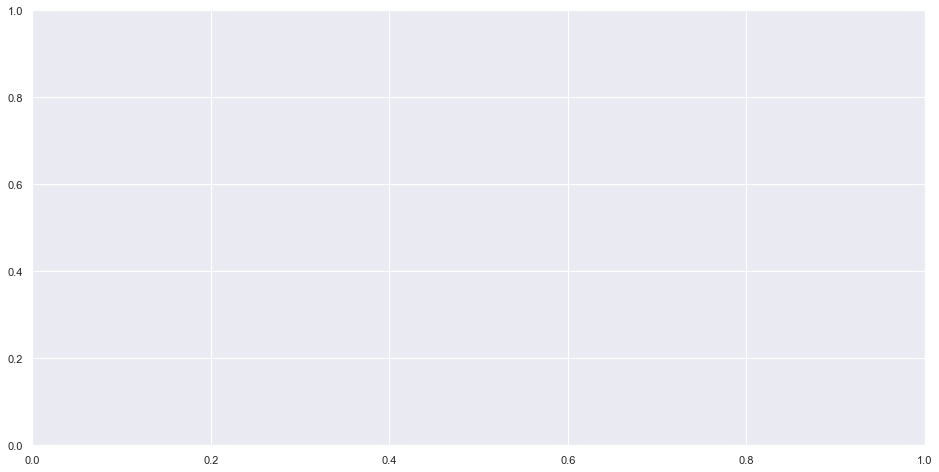

In [9]:
tsne_visualize1(alpha, rho, beta, topwords = 5)

In [6]:
# BARPLOT TOP WORDS PER TOPIC

import seaborn as sns
import pandas as pd

def barplot_topwords(beta, vocab, topic, topwords=10):
    topK=np.argsort(-1 * beta[topic,])[0:topwords]
    data = {'word':[str(vocab[i]) for i in list(topK)],'beta':list(beta[topic,topK])}
    df = pd.DataFrame(data)
    sns.barplot(x='beta', y='word', data = df, color='black', orient='h')


In [4]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST IMPORTANT

top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
data = {'θ':list(range(T)),'counts':count_top_topics}
df = pd.DataFrame(data)
sns.barplot(x='θ', y='counts', data = df, color='black')
plt.show()


NameError: name 'theta' is not defined

In [ ]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS DETECTED (Θ above a threshold)

theta_threshold=1/T
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic':list(range(T)),'ndocs':list(topic_ndocs)}
df = pd.DataFrame(data)
sns.barplot(x='topic', y='ndocs', data = df, color='black')
plt.show()

In [5]:
# TOPIC DISTRIBUTION BY DOCUMENT

def get_doc_representation(theta, doc):
    data = {'topic':list(range(T)),'topic distribution in doc i':list(theta[doc,])}
    df = pd.DataFrame(data)
    sns.barplot(x='topic', y='topic distribution in doc i', data = df, color='black')
    plt.show()


In [8]:
# HISTOGRAM NUM. WORDS IN EACH DOCUMENT

#length_docs=np.random.poisson(lam=1000, size=theta.shape[0])
sns.histplot(length_docs).set(xlabel='num. words', ylabel='counts')
plt.axvline(np.mean(length_docs), linewidth=2.5, color='black')
plt.axvline(np.percentile(length_docs, 25), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 50), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 75), linestyle='--', color='black')
plt.legend('topright', labels=['mean', 'quartiles'])
plt.show()


NameError: name 'length_docs' is not defined

In [9]:
# METRICS PLOT TO COMPARE METHODS
# metrics = 2-dim array, rows: methods, columns: num topic
# method_labels = list of strings with names of the methods
# num_topic = list of integers, ex. [10,20,30,40,50]

def metrics_plot(metrics,method_labels,num_topic):
    for i in range(num_metrics):
        plt.plot(num_topic,metrics[i,], label=method_labels[i])
    plt.legend()
    plt.xticks(num_topic)
    plt.show()